In [1]:
import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from proteins.config import flatten_dict

ix = pd.IndexSlice
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [2]:
from collections import defaultdict

df = defaultdict(list)
bad = []

for p in Path('.').glob('runs/*/*.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        bad.append(p)
    else:
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_cached_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['metric']):
            df[('metric', *k, '')].append(v)
        
df = pd.DataFrame(df).sort_index(axis='columns', inplace=False)
        
print(f'Skipped {len(bad)}')
print(f'Good {len(df)}')
df.iloc[0].to_frame()

Skipped 0
Good 135


0
hp     data         cutoff                           6                          
                    encoding_base                    NaN                        
                    encoding_size                    0                          
       epochs                                        20                         
       loss         global_gdtts           balanced  False                      
                                           name      mse                        
                                           weight    1                          
                    global_lddt            balanced  False                      
                                           name      mse                        
                                           weight    1                          
                    local_lddt             balanced  False                      
                                           name      mse                        
                                           weight    10                         
       model        batch_norm                       False                      
                    dropout                          0.4                        
                    fn                               proteins.networks.ProteinGN
                    layers                           6                          
                    mp_in_edges                      128                        
                    mp_in_globals                    64                         
                    mp_in_nodes                      256                        
                    mp_out_edges                     8                          
                    mp_out_globals                   4                          
                    mp_out_nodes                     16                         
       optimizer    fn                               torch.optim.Adam           
                    lr                               0.001                      
                    weight_decay                     1e-05                      
metric global_gdtts correlation                      0.826742                   
                    correlation_per_target           0.545477                   
                    first_rank_loss                  0.151577                   
                    r2                               0.56673                    
                    rmse                             0.192558                   
       global_lddt  correlation                      0.891982                   
                    correlation_per_target           0.723484                   
                    first_rank_loss                  0.0473357                  
                    r2                               0.709445                   
                    rmse                             0.10472                    
       local_lddt   correlation                      0.82703                    
                    correlation_per_model            0.550536                   
                    r2                               0.608474                   
                    rmse                             0.144142                   
misc   gpu                                           7172                       
       name                                          compassionate_lumiere      
       time                                          43.2109

In [3]:
fixed_hps = df.hp.nunique() == 1
display(df.hp.loc[[0], fixed_hps.values].rename(index={0:'Fixed parameters'}))

# Always keep cutoff because we plot it later
df.drop(columns=(('hp', *c) for c in fixed_hps[fixed_hps.values].index.remove_unused_levels() if c[1] != 'cutoff'), inplace=True)
df.columns = df.columns.remove_unused_levels()
df.sort_index(axis='columns', inplace=True)

data epochs         loss                               \
                 cutoff        global_gdtts             global_lddt        
                                   balanced name weight    balanced name   
Fixed parameters  6      20     False        mse  1      False       mse   

                                                    model  \
                        local_lddt             batch_norm   
                 weight   balanced name weight              
Fixed parameters  1      False      mse  10     False       

                                                      optimizer         \
                                           fn                fn     lr   
                                                                         
Fixed parameters  proteins.networks.ProteinGN  torch.optim.Adam  0.001   

                               
                 weight_decay  
                               
Fixed parameters  0.00001

In [4]:
display(df[df.metric.isna().any(axis=1)].style.set_caption('Something went wrong here'))
df = df[~df.metric.isna().any(axis=1)]

## What's the best we can do?

In [5]:
pd.concat((
    df.loc[df['metric', 'local_lddt', 'correlation'].idxmax()].to_frame('Local LDDT'),
    df.loc[df['metric', 'global_lddt', 'correlation_per_target'].idxmax()].to_frame('Global LDDT per target'),
    df.loc[df['metric', 'global_gdtts', 'correlation_per_target'].idxmax()].to_frame('Global GDT_TS per target'),
), axis='columns') \
.style \
.apply(lambda x: ['color: green; font-weight: bold' if v == x.max() else '' for v in x], subset=ix['metric', 'local_lddt', 'correlation'], axis=1) \
.apply(lambda x: ['color: green; font-weight: bold' if v == x.max() else '' for v in x], subset=ix['metric', 'global_lddt', 'correlation_per_target'], axis=1) \
.apply(lambda x: ['color: green; font-weight: bold' if v == x.max() else '' for v in x], subset=ix['metric', 'global_gdtts', 'correlation_per_target'], axis=1)

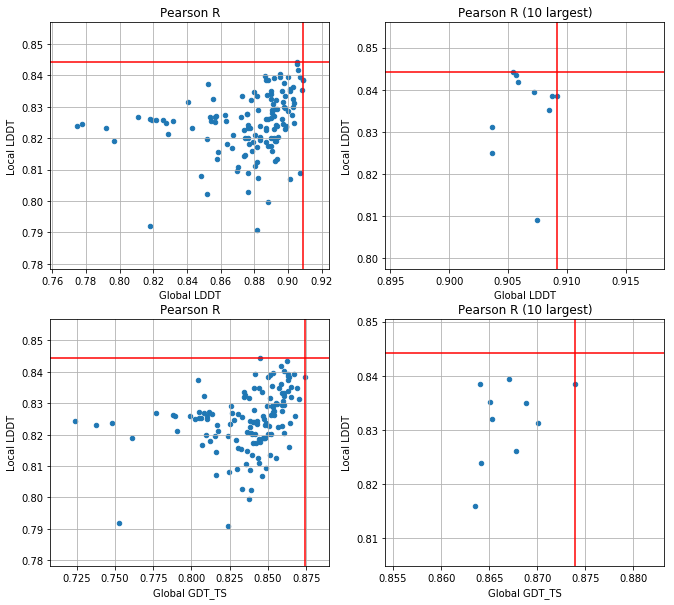

In [6]:
fig, axes = plt.subplots(2,2, figsize=(11, 10))

ax = axes.flat[0]
df.plot.scatter(ix['metric', 'global_lddt', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R')
ax.set_xlabel('Global LDDT')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_lddt', 'correlation'].max(), c='r')
ax.grid()

ax = axes.flat[1]
df.nlargest(10, [ix['metric', 'global_lddt', 'correlation'], ix['metric', 'local_lddt', 'correlation']]).plot.scatter(ix['metric', 'global_lddt', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R (10 largest)')
ax.set_xlabel('Global LDDT')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_lddt', 'correlation'].max(), c='r')
ax.grid()

ax = axes.flat[2]
df.plot.scatter(ix['metric', 'global_gdtts', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R')
ax.set_xlabel('Global GDT_TS')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_gdtts', 'correlation'].max(), c='r')
ax.grid()

ax = axes.flat[3]
df.nlargest(10, [ix['metric', 'global_gdtts', 'correlation'], ix['metric', 'local_lddt', 'correlation']]).plot.scatter(ix['metric', 'global_gdtts', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R (10 largest)')
ax.set_xlabel('Global GDT_TS')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_gdtts', 'correlation'].max(), c='r')
ax.grid()

In [7]:
df.nlargest(10, [ix['metric', 'local_lddt', 'correlation'], ix['metric', 'global_lddt', 'correlation'], ix['metric', 'global_gdtts', 'correlation']]) \
    .rename(columns=lambda s: s.replace('mp_', ''), level=2) \
    .style.highlight_max(color='green', subset=[ix['metric', 'global_lddt', 'correlation', ''], ix['metric', 'local_lddt', 'correlation', ''], ix['metric', 'global_gdtts', 'correlation', '']]) \
    .hide_index()

## Resources usage

In [8]:
df.nlargest(10, ix['misc', 'gpu']) \
    .rename(columns=lambda s: s.replace('mp_', ''), level=1) \
    .drop(columns=['metric'], level=0) \
    .style \
    .hide_index()

In [9]:
df.nlargest(10, ix['misc', 'time']) \
    .rename(columns=lambda s: s.replace('mp_', ''), level=1) \
    .drop(columns=['metric'], level=0) \
    .style \
    .hide_index()

## How do RMSE and R2 correlate with Pearson R?

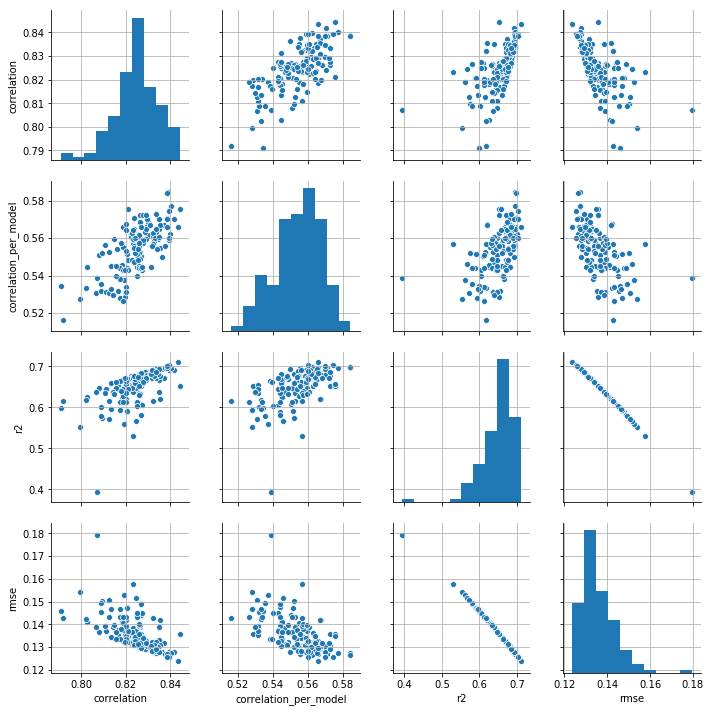

In [10]:
pg = sns.pairplot(df['metric', 'local_lddt'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

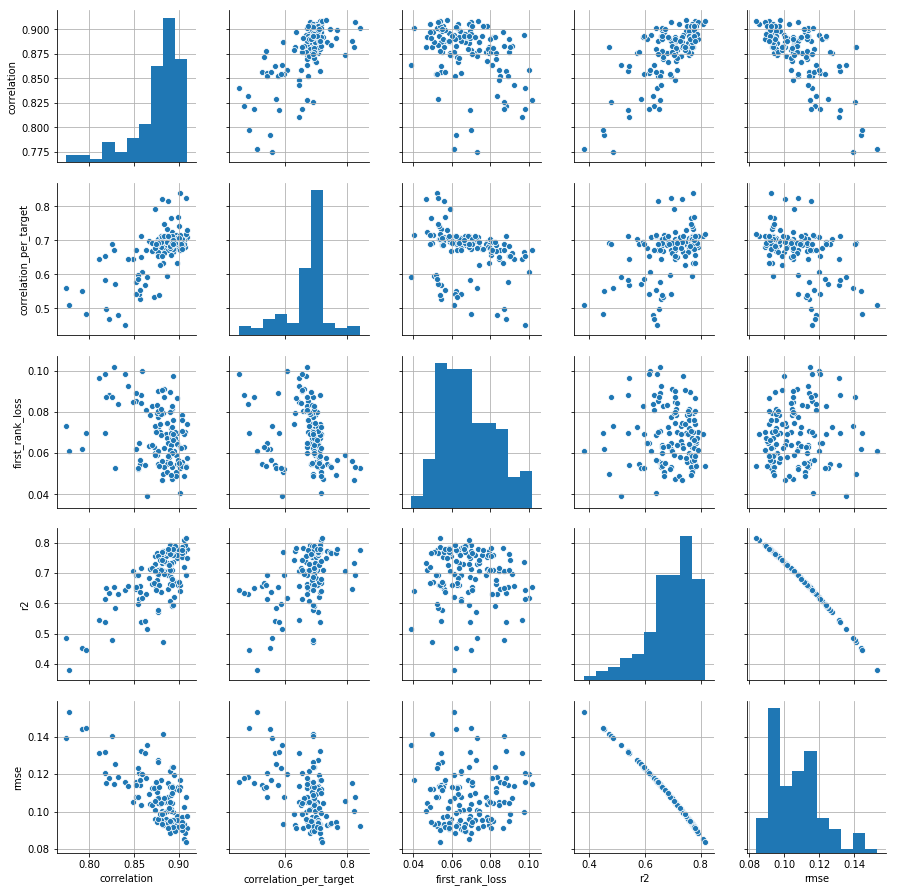

In [11]:
pg = sns.pairplot(df['metric', 'global_lddt'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

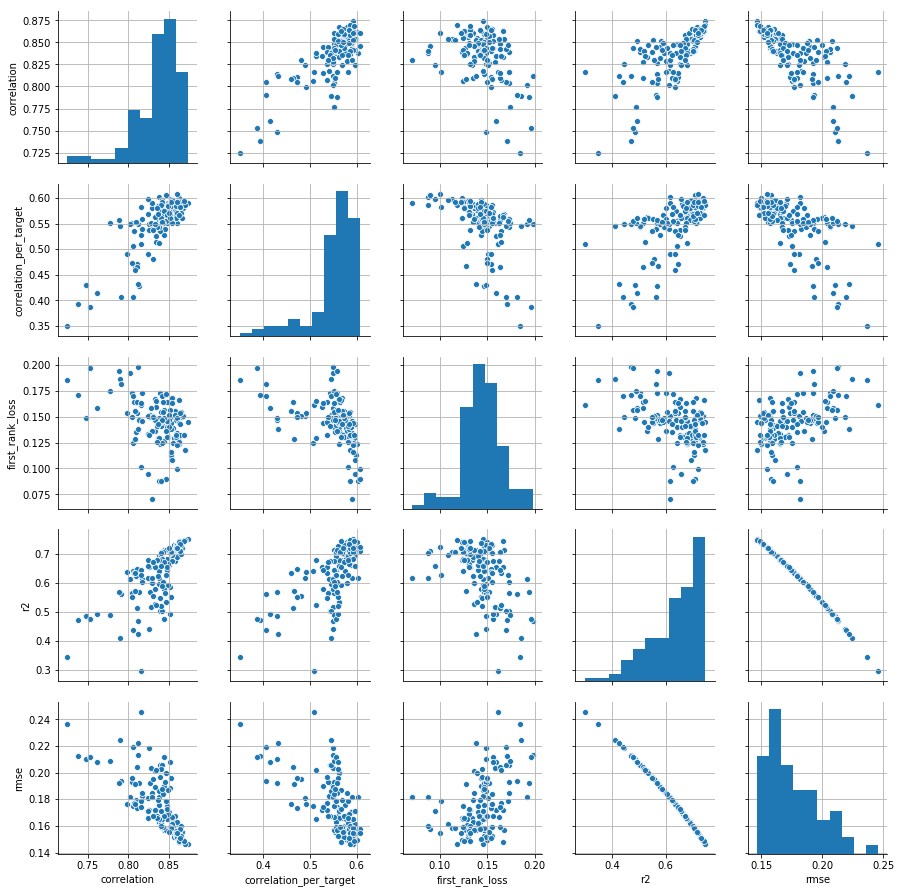

In [12]:
pg = sns.pairplot(df['metric', 'global_gdtts'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

## Global vs local

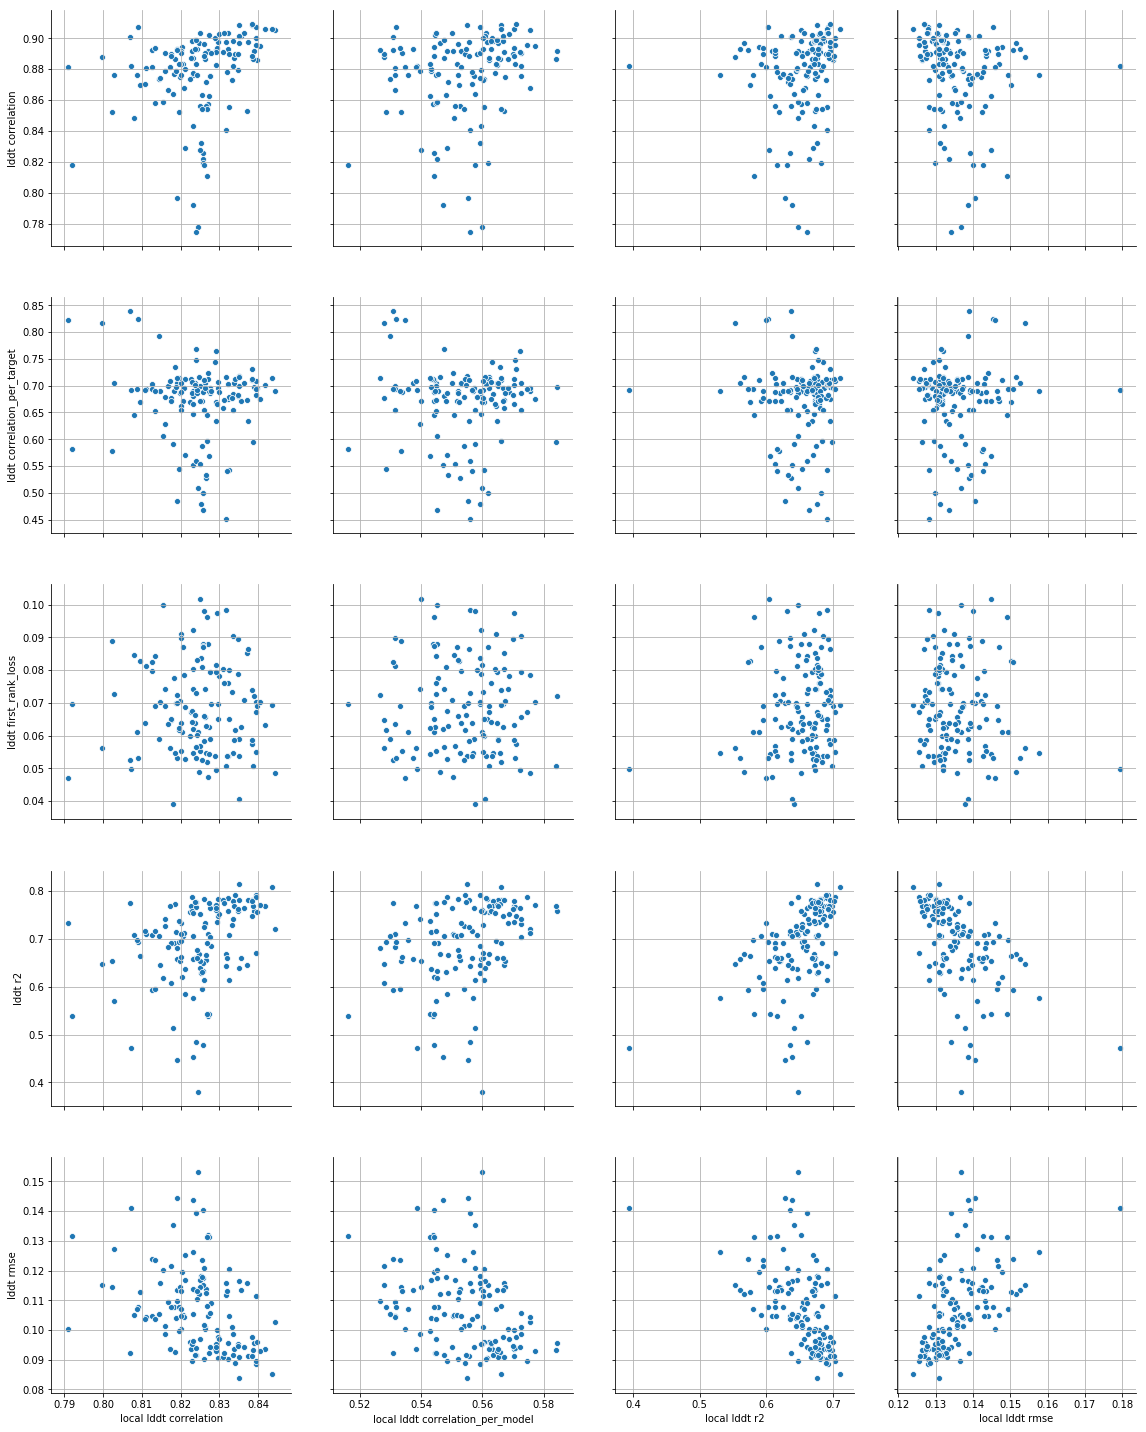

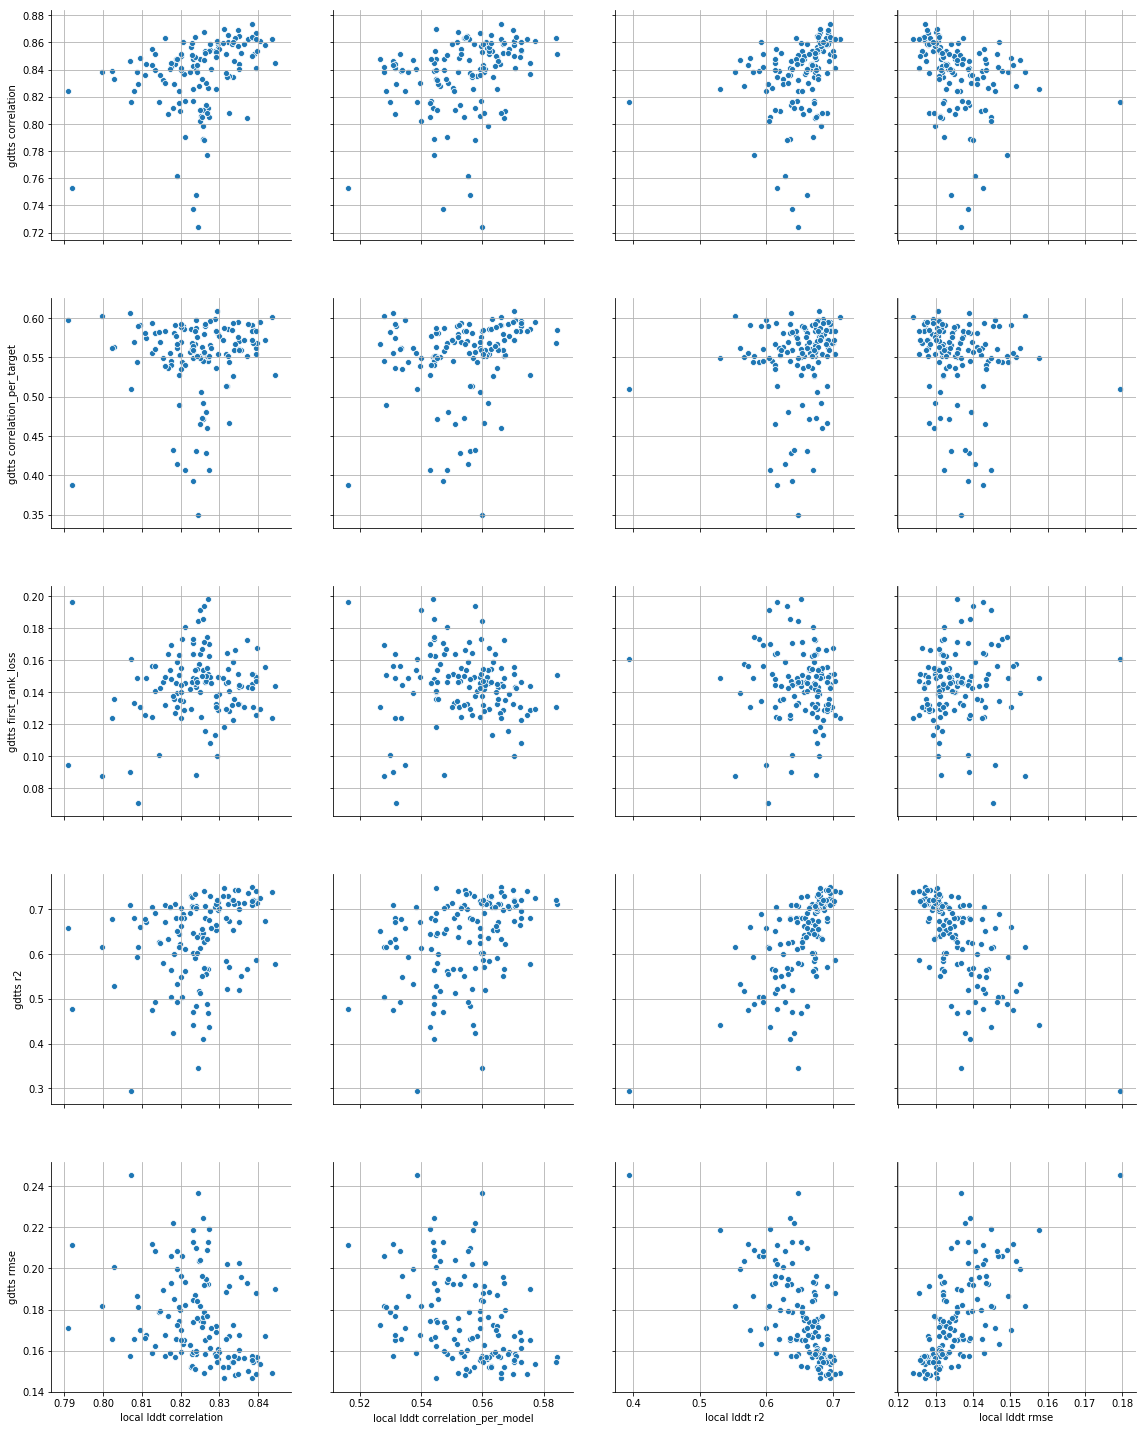

In [13]:
for g in ('global_lddt', 'global_gdtts'):
    pg = sns.pairplot(
        df, 
        height=4,
        y_vars=list(c for c in df.columns if c[0] == 'metric' and c[1] == g),
        x_vars=list(c for c in df.columns if c[0] == 'metric' and c[1] == 'local_lddt')
    )
    
    for ax in pg.axes.ravel():
        ax.grid()
        if len(ax.get_xlabel()) > 0:
            ax.set_xlabel('local lddt ' + ax.get_xlabel().split("'")[5])
        if len(ax.get_ylabel()) > 0:
            split = ax.get_ylabel().split("'")
            ax.set_ylabel(f'{split[3][7:]} {split[5]}')

## Parameters

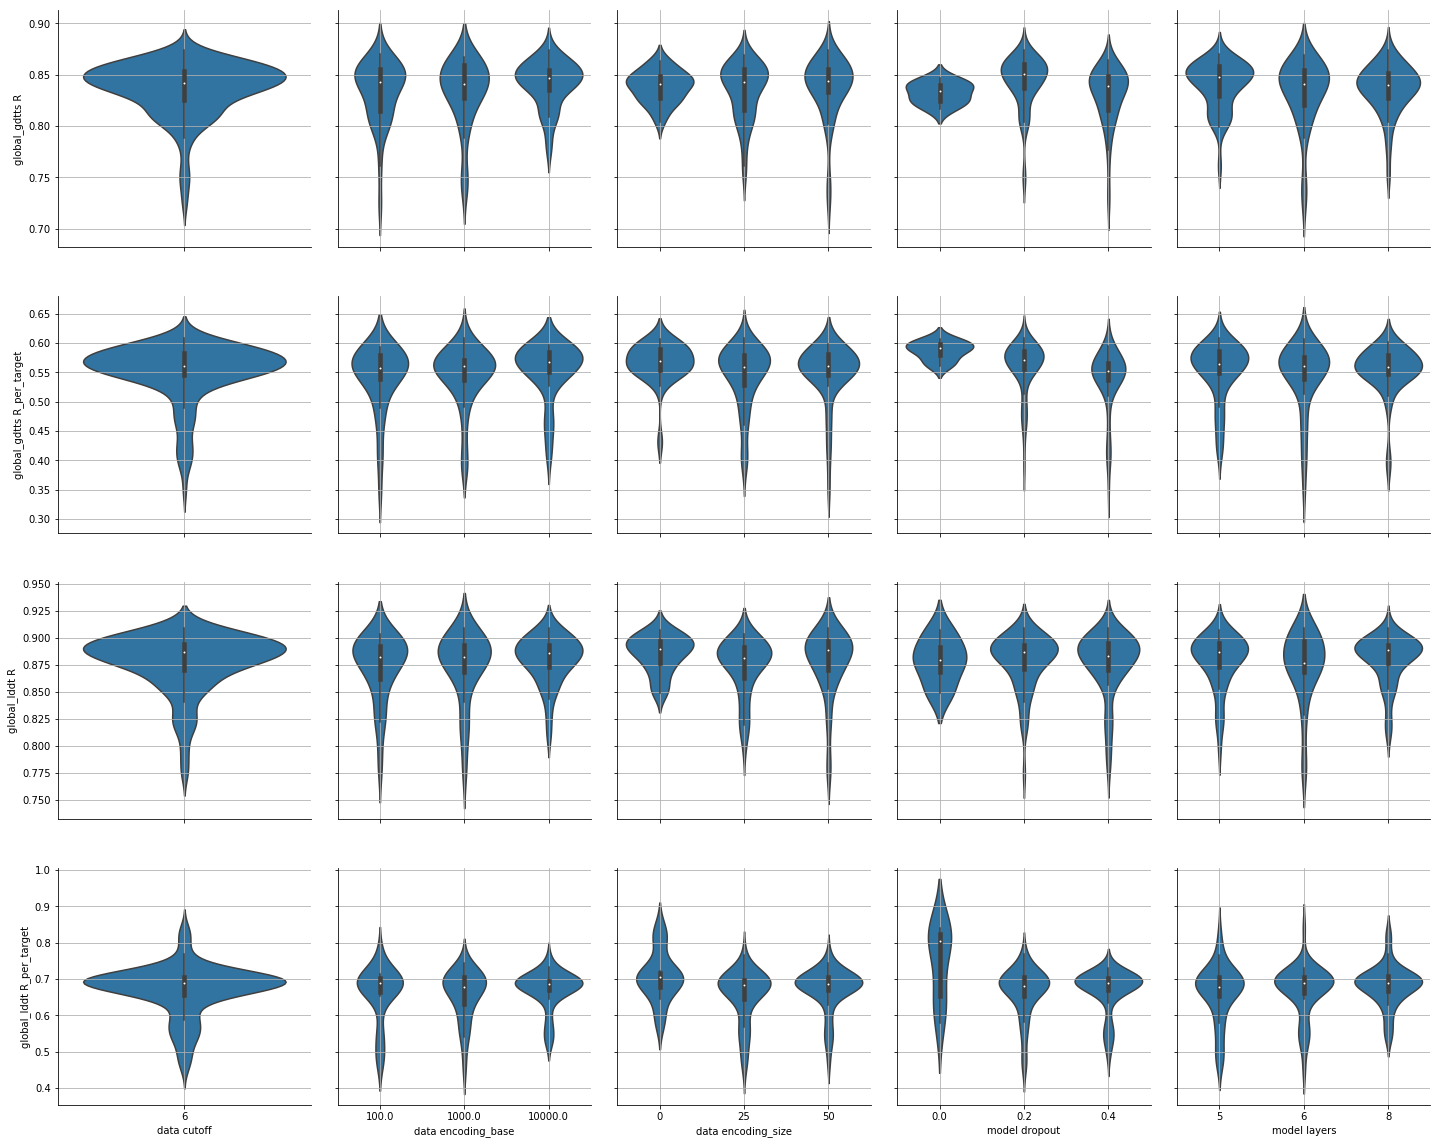

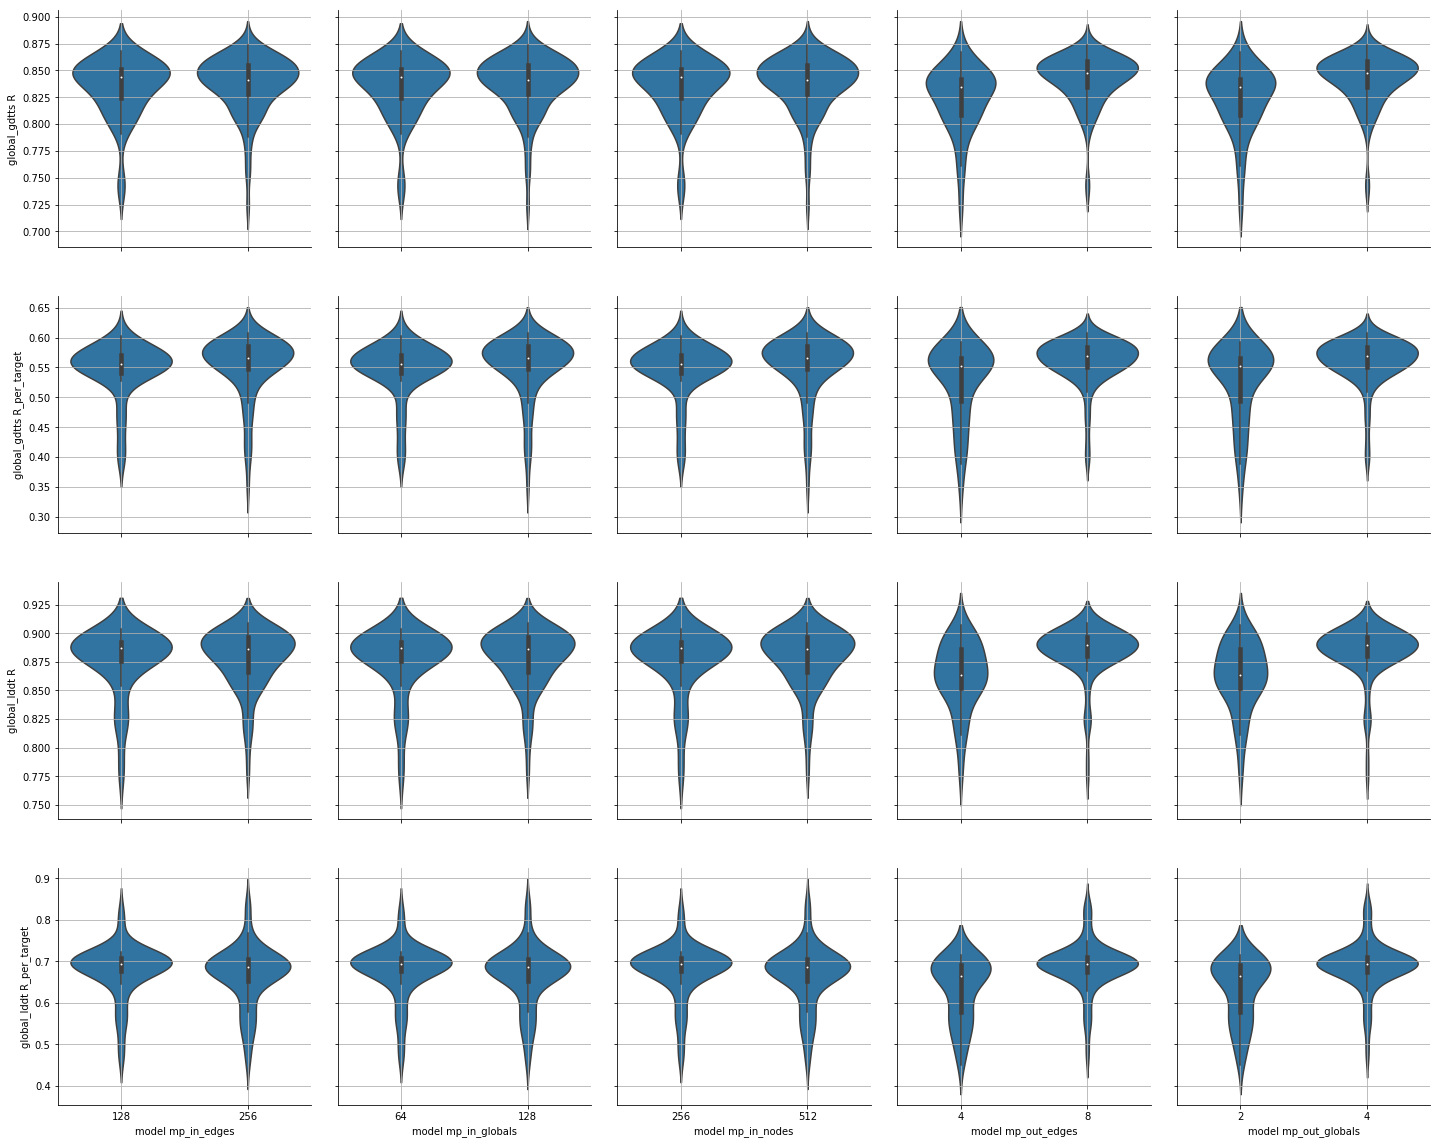

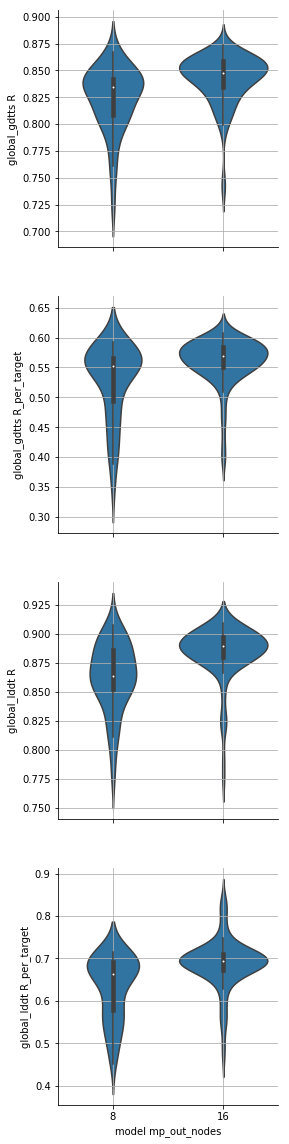

In [14]:
metrics = list(c for c in df.columns if c[0] == 'metric' and c[1].startswith('global') and c[2].startswith('correlation'))
hps = list(c for c in df.columns if c[0] == 'hp')

for i in range(0, len(hps), 5):
    pg = sns.PairGrid(
        df,
        height=4,
        y_vars=metrics,
        x_vars=hps[i: i+5],
    )
    pg.map(sns.violinplot)
    for ax in pg.axes.ravel():
        ax.grid()
    for ax, name in zip(pg.axes[-1, :], (' '.join(hp[1:]).strip() for hp in hps[i: i+5])):
        ax.set_xlabel(name)
    for ax, name in zip(pg.axes[:, 0], (m[1] + ' ' + m[2].replace('correlation', 'R') for m in metrics)):
        ax.set_ylabel(name)

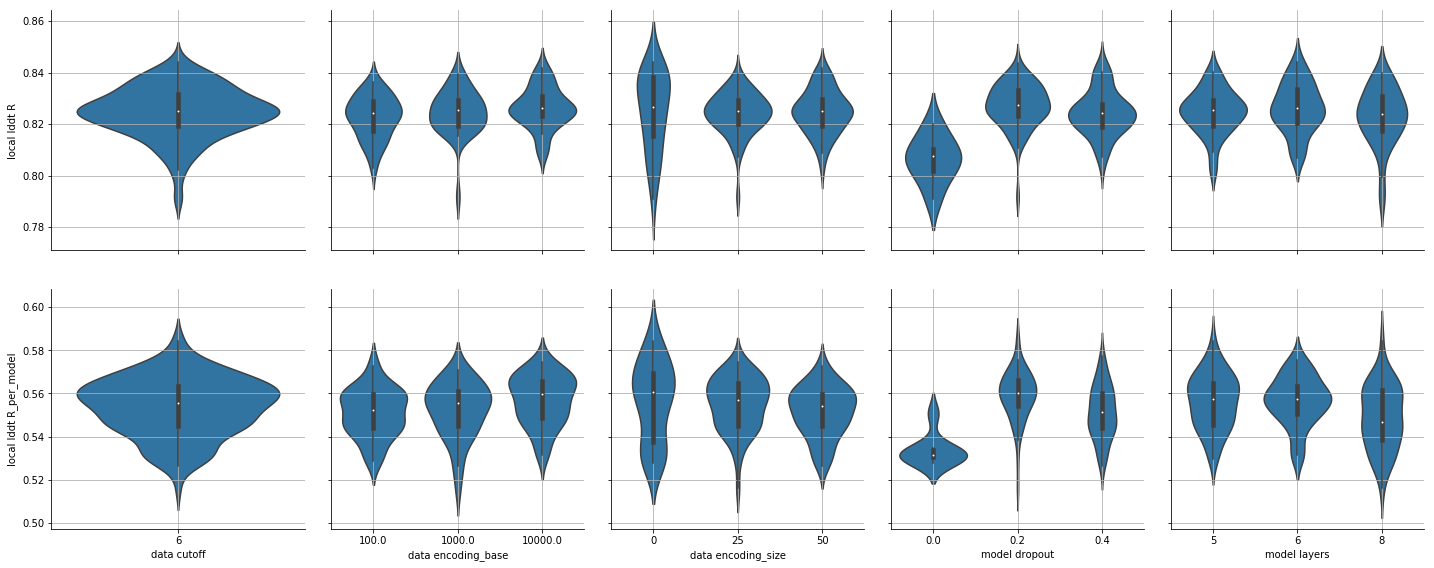

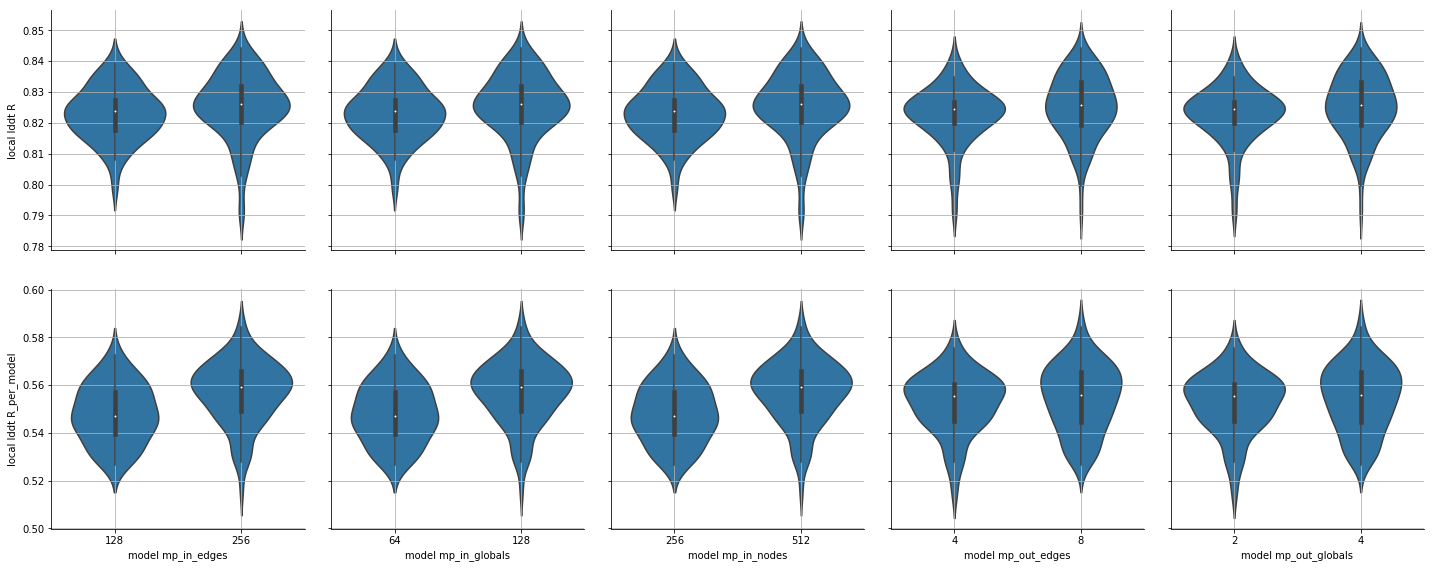

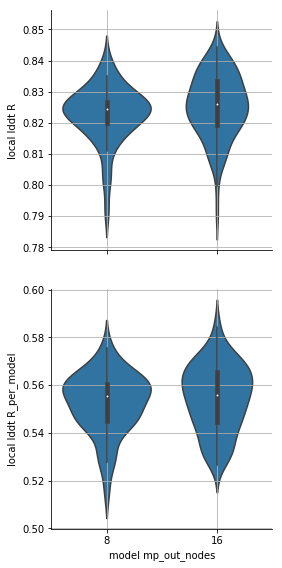

In [15]:
metrics = list(c for c in df.columns if c[0] == 'metric' and c[1] == 'local_lddt' and c[2].startswith('correlation'))
hps = list(c for c in df.columns if c[0] == 'hp')

for i in range(0, len(hps), 5):
    pg = sns.PairGrid(
        df,
        height=4,
        y_vars=metrics,
        x_vars=hps[i: i+5],
    )
    pg.map(sns.violinplot)
    for ax in pg.axes.ravel():
        ax.grid()
    for ax, name in zip(pg.axes[-1, :], (' '.join(hp[1:]).strip() for hp in hps[i: i+5])):
        ax.set_xlabel(name)
    for ax, name in zip(pg.axes[:, 0], ('local lddt ' + m[2].replace('correlation', 'R') for m in metrics)):
        ax.set_ylabel(name)

### Layers vs cutoff
- trade off between local and global

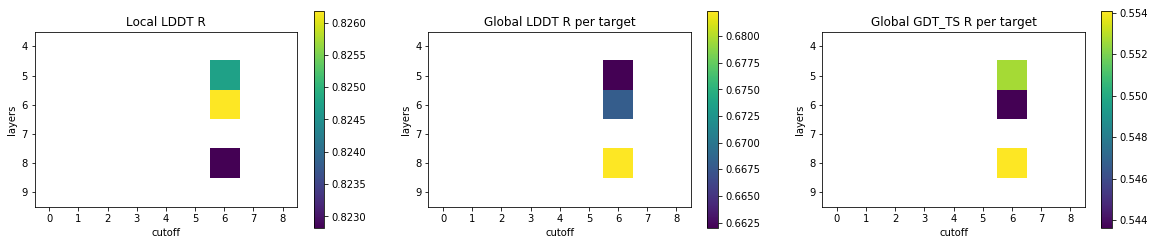

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_cutoff_layers = df.groupby(by=[ix['hp', 'data', 'cutoff'], ix['hp', 'model', 'layers']]) \
    .apply(lambda df: df.metric.mean()) \
    .reindex(pd.MultiIndex.from_product([range(0,9), range(4, 10)], names=['cutoff', 'layers'])) \
    .unstack('cutoff')

metrics = {
    'Local LDDT R': df_cutoff_layers['local_lddt', 'correlation'], 
    'Global LDDT R per target': df_cutoff_layers['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_cutoff_layers['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('cutoff')
    ax.set_xticks(range(len(df_img.columns.get_level_values('cutoff'))))
    ax.set_xticklabels(df_img.columns.get_level_values('cutoff'))
    ax.set_ylabel('layers')
    ax.set_yticks(range(len(df_img.index.get_level_values('layers'))))
    ax.set_yticklabels(df_img.index.get_level_values('layers'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

### Layers vs dropout
- Keeping dropout low helps, so maybe increase network size?

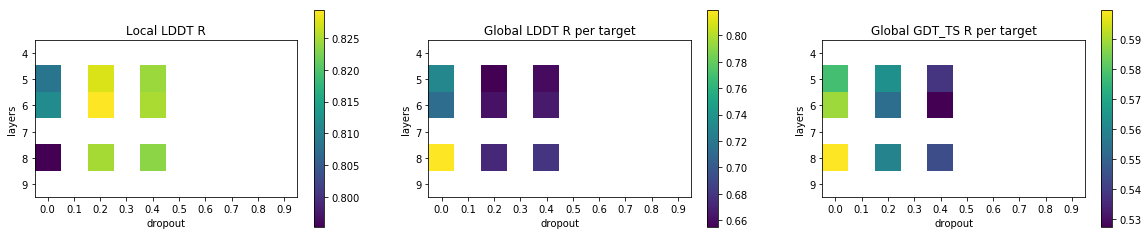

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_dropout_layers = df.groupby(by=[ix['hp', 'model', 'dropout'], ix['hp', 'model', 'layers']]) \
    .apply(lambda df: df.metric.mean()) \
    .reindex(pd.MultiIndex.from_product([np.linspace(0, 1, 10, endpoint=False).round(1), range(4, 10)], names=['dropout', 'layers'])) \
    .unstack('dropout')

metrics = {
    'Local LDDT R': df_dropout_layers['local_lddt', 'correlation'], 
    'Global LDDT R per target': df_dropout_layers['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_dropout_layers['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('dropout')
    ax.set_xticks(range(len(df_img.columns.get_level_values('dropout'))))
    ax.set_xticklabels(df_img.columns.get_level_values('dropout'))
    ax.set_ylabel('layers')
    ax.set_yticks(range(len(df_img.index.get_level_values('layers'))))
    ax.set_yticklabels(df_img.index.get_level_values('layers'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

In [18]:
df_encsize_encbase = df.fillna({('hp', 'data', 'encoding_base', ''): 0}) \
    .groupby(by=[ix['hp', 'data', 'encoding_size'], ix['hp', 'data', 'encoding_base']]) \
    .apply(lambda df: df.metric.mean())
df_encsize_encbase.index.names = ['enc size', 'enc_base']
df_encsize_encbase = df_encsize_encbase.unstack('enc size')

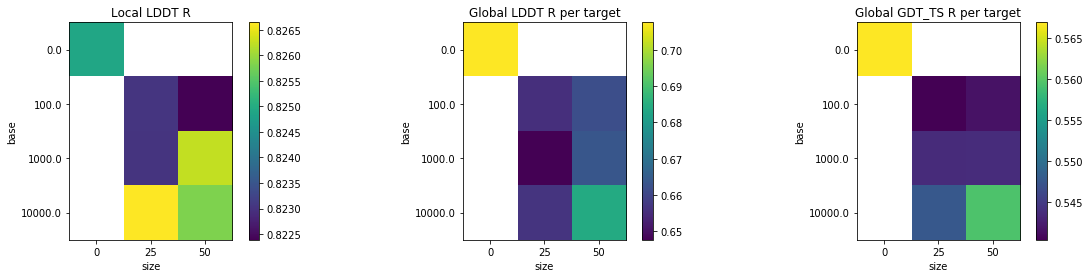

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_encsize_encbase = df.fillna({('hp', 'data', 'encoding_base', ''): 0}) \
    .groupby(by=[ix['hp', 'data', 'encoding_size'], ix['hp', 'data', 'encoding_base']]) \
    .apply(lambda df: df.metric.mean())
df_encsize_encbase.index.names = ['enc size', 'enc base']
df_encsize_encbase = df_encsize_encbase.unstack('enc size')

metrics = {
    'Local LDDT R': df_encsize_encbase['local_lddt', 'correlation'], 
    'Global LDDT R per target': df_encsize_encbase['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_encsize_encbase['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('size')
    ax.set_xticks(range(len(df_img.columns.get_level_values('enc size'))))
    ax.set_xticklabels(df_img.columns.get_level_values('enc size'))
    ax.set_ylabel('base')
    ax.set_yticks(range(len(df_img.index.get_level_values('enc base'))))
    ax.set_yticklabels(df_img.index.get_level_values('enc base'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))